In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchsummary import summary

In [3]:
# using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# ensuring reproducibility of code
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# loading data

batch_size = 128

transform = transforms.Compose(
    [transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


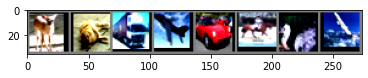

deer cat truck plane car horse bird plane


In [6]:
def imshow(img):
    """
    function to plot images.
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[0:8]

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%s' % classes[labels[j]] for j in range(8)))

In [7]:
class AutoConv2d_BN(nn.Module):
    """
    custom block that implements 'same' padding for a convolution followed by 
    batch normalisation
    """
    def __init__(self, input_channels, output_channels, kernel_size, stride = 1):
        super(AutoConv2d_BN, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, 
                              kernel_size = kernel_size, 
                              padding = kernel_size // 2, stride = stride)
        self.bn = nn.BatchNorm2d(output_channels)
    
    def forward(self, x):
        x = self.bn(self.conv(x))
        return x

In [8]:
class VanillaResBlock(nn.Module):
    """
    simple residual block with 2 `AutoConv2d_BN` layers and a shortcut mapping
    """
    def __init__(self, input_channels, output_channels, kernel_size):
        super(VanillaResBlock, self).__init__()
        self.conv = AutoConv2d_BN(input_channels, output_channels, 
                                  kernel_size = kernel_size)

    def forward(self, x):
        input = x
        x = F.relu(self.conv(x))
        x = F.relu(self.conv(x))
        x = x + input
        return x

In [9]:
class BottleneckResBlock(nn.Module):
    """
    bottleneck residual block to reduce compute in the deeper layers
    """
    def __init__(self, input_channels, bottleneck_channels, output_channels, kernel_size):
        super(BottleneckResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, bottleneck_channels, 
                                   kernel_size = 1)
        self.conv2 = AutoConv2d_BN(bottleneck_channels, bottleneck_channels, 
                                   kernel_size = kernel_size)
        self.conv3 = AutoConv2d_BN(bottleneck_channels, output_channels, 
                                   kernel_size = 1)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x + input
        return x

In [10]:
class DownsampleResBlock(nn.Module):
    """
    simple residual block with downsampling of images
    """
    def __init__(self, input_channels, output_channels, kernel_size, down_stride):
        super(DownsampleResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = kernel_size, stride = down_stride)
        self.conv2 = AutoConv2d_BN(output_channels, output_channels, 
                                   kernel_size)
        self.conv3 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = 1, stride = down_stride)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x + self.conv3(input)
        return x

In [11]:
class DownbottleResBlock(nn.Module):
    """
    bottleneck block that downsamples images
    """
    def __init__(self, input_channels, bottleneck_channels , output_channels, kernel_size, down_stride):
        super(DownbottleResBlock, self).__init__()
        self.conv1 = AutoConv2d_BN(input_channels, bottleneck_channels, 
                                   kernel_size = 1)
        self.conv2 = AutoConv2d_BN(bottleneck_channels, bottleneck_channels, 
                                   kernel_size = kernel_size, stride = down_stride)
        self.conv3 = AutoConv2d_BN(bottleneck_channels, output_channels, 
                                   kernel_size = 1)
        self.conv4 = AutoConv2d_BN(input_channels, output_channels, 
                                   kernel_size = 1, stride = down_stride)

    def forward(self, x):
        input = x
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x + self.conv4(input)
        return x

In [12]:
class ResNetlike(nn.Module):
    """
    returns ResNet-like neural network architecture.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.block1 = VanillaResBlock(32, 32, 3)
        self.block2 = DownsampleResBlock(32, 64, 3, 2)
        self.block3 = BottleneckResBlock(64, 32, 64, 3)
        self.block4 = DownbottleResBlock(64, 32, 128, 3, 2)
        self.block5 = BottleneckResBlock(128, 64, 128, 3)
        self.block6 = DownbottleResBlock(128, 64, 256, 3, 2)
        self.gap = nn.AvgPool2d((4, 4))
        self.fc = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block1(x)
        x = self.dropout(x)
        x = self.block2(x)
        x = self.dropout(x)
        x = self.block3(x)
        x = self.block3(x)
        x = self.dropout(x)
        x = self.block4(x)
        x = self.dropout(x)
        x = self.block5(x)
        x = self.block5(x)
        x = self.dropout(x)
        x = self.block6(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
# moving net to GPU
net = ResNetlike()
net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
            Conv2d-2           [-1, 32, 28, 28]           9,248
       BatchNorm2d-3           [-1, 32, 28, 28]              64
     AutoConv2d_BN-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           9,248
       BatchNorm2d-6           [-1, 32, 28, 28]              64
     AutoConv2d_BN-7           [-1, 32, 28, 28]               0
   VanillaResBlock-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
    AutoConv2d_BN-11           [-1, 32, 28, 28]               0
           Conv2d-12           [-1, 32, 28, 28]           9,248
      BatchNorm2d-13           [-1, 32, 28, 28]              64
    AutoConv2d_BN-14           [-1, 32,

In [14]:
# defining loss, optimizer and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr = 3e-3, weight_decay = 1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100, 150, 175])

In [15]:
# training loop

for epoch in range(200):  # loop over the dataset multiple times
    running_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    scheduler.step()

    # print statistics
    accuracy = 100 * (correct / total)
    print("Epoch", epoch + 1)
    print(f'  Accuracy of the network on the {total} training images: {accuracy}')
    print(f'  Loss of the network on the {total} training images: {running_loss}')

print('Finished Training')

Epoch 1
  Accuracy of the network on the 50000 training images: 42.872
  Loss of the network on the 50000 training images: 604.2170714139938
Epoch 2
  Accuracy of the network on the 50000 training images: 57.998000000000005
  Loss of the network on the 50000 training images: 455.9777561426163
Epoch 3
  Accuracy of the network on the 50000 training images: 64.544
  Loss of the network on the 50000 training images: 388.9951670765877
Epoch 4
  Accuracy of the network on the 50000 training images: 68.428
  Loss of the network on the 50000 training images: 347.3376929759979
Epoch 5
  Accuracy of the network on the 50000 training images: 71.848
  Loss of the network on the 50000 training images: 311.9298965334892
Epoch 6
  Accuracy of the network on the 50000 training images: 74.158
  Loss of the network on the 50000 training images: 287.82085102796555
Epoch 7
  Accuracy of the network on the 50000 training images: 76.03999999999999
  Loss of the network on the 50000 training images: 269.142

In [16]:
# saving weights of model
model_save_name = 'cifarresnetlike.pt'
path = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}" 
torch.save(net.state_dict(), path)

In [17]:
# loading model
model_save_name = 'cifarresnetlike.pt'
PATH = f"/content/gdrive/My Drive/Deep Learning/pytorch-experiments/Vision/{model_save_name}"
model_state_dict = torch.load(PATH)
model = ResNetlike()
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [18]:
# moving model to GPU
model.to(device)

ResNetlike(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (block1): VanillaResBlock(
    (conv): AutoConv2d_BN(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): DownsampleResBlock(
    (conv1): AutoConv2d_BN(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): AutoConv2d_BN(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): AutoConv2d_BN(
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block3): BottleneckResBlock(
    (conv1): AutoCon

In [19]:
# evaluating on test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}')

Accuracy of the network on the 10000 test images: 88.9
